In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import tensorflow as tf
import keras
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

In [45]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train"
val_path = Path(root) / "Phase2" / "Data" / "Val"
train_gen = DataGenerator(train_path,
                          mode="unsupervised",
                          rho=32,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised",
                          rho=32,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=( (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),#input
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     
                     tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32) # output
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
print(sample_output.shape)

reshuffling dataset
input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)


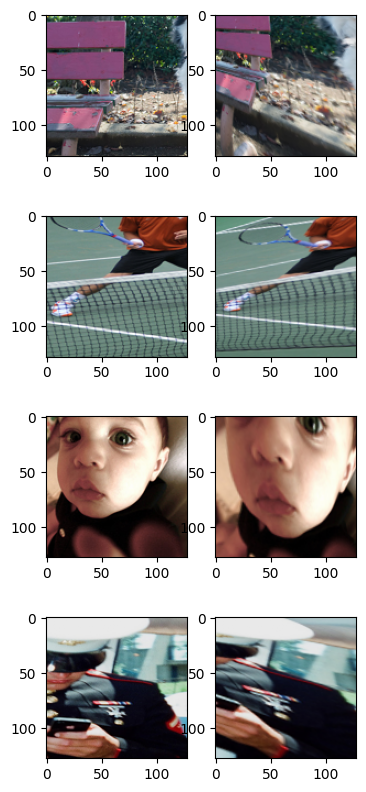

In [46]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [47]:
# build new model with TensorDLT and STN added
homography_net = model_v2()

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

full_model = keras.Model(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], outputs=img_pred)
full_model.summary()


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_47 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_17 (Functional)       (None, 8)                    3777980   ['input_46[0][0]',            
                                                          0          'input_47[0][0]']            
                                                                                                  
 tf.reshape_22 (TFOpLambda)  (None, 4, 2)                 0         ['model_17[0][0]']     

In [48]:
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
print(sample_model_output.shape)
assert(sample_model_output.shape==sample_input[2].shape)

(8, 240, 320, 3)


In [49]:
# define loss and metrics
def custom_loss_unsupervised(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) # notice 1-norm is used

# compile model
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
              loss=custom_loss_unsupervised)

In [50]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))
# start training
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = './checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_freq = steps_per_epoch*10
    )

history = full_model.fit(train_ds,
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds,
                         validation_steps=int(np.floor(1000/batch_size)),
                         validation_freq=1,
                         verbose=True,
                         callbacks=[reduce_lr, checkpoint_callback])

Epoch 1/100


 34/625 [>.............................] - ETA: 6:12 - loss: 54.1297

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


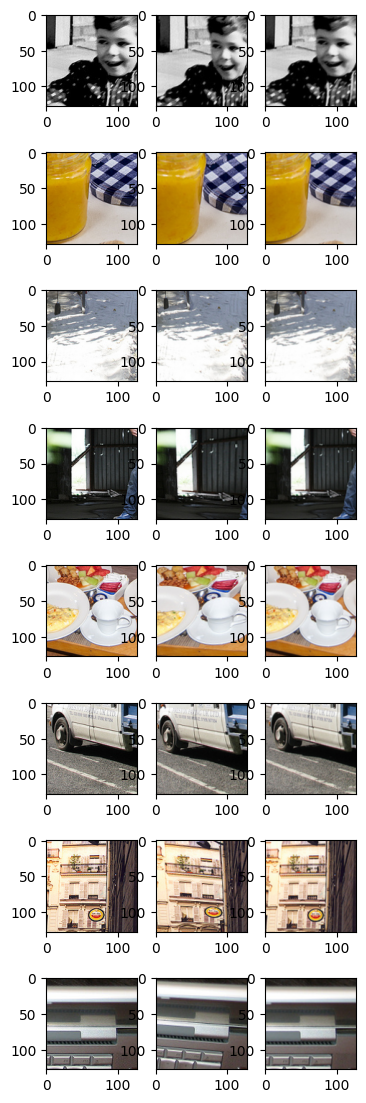

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()